In [14]:
# If we are on colab: this clones the repo and installs the dependencies
from pathlib import Path
from omegaconf import OmegaConf
from gluefactory.datasets import get_dataset
import torch

torch.set_grad_enabled(True)
images = Path("assets")

from gluefactory.models import get_model
from matplotlib import pyplot as plt
import numpy as np

In [15]:
conf = OmegaConf.load("gluefactory/configs/superpoint+simpleglue_homography_test.yaml")

In [16]:
data_conf = (conf.data)
dataset = get_dataset(data_conf.name)(data_conf)

[08/16/2024 13:11:11 gluefactory.datasets.base_dataset INFO] Creating dataset HomographyDataset
[08/16/2024 13:11:11 gluefactory.datasets.homographies INFO] Found 12 images in list file.


In [17]:
train_loader = dataset.get_data_loader("train", distributed=False)


In [18]:
model = get_model(conf.model.name)(conf.model).to('cpu')

In [21]:
# train the model
tot_steps = 1000
lr = 8e-5
params = [(n, p) for n, p in model.named_parameters() if p.requires_grad]
all_params = [p for n, p in params]
optimizer = torch.optim.Adam(all_params, lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
        lr, tot_steps, pct_start=0.01, cycle_momentum=False, anneal_strategy='linear')

step = 0
data = next(iter(train_loader))
while(step < tot_steps):
    # for _, data in enumerate(train_loader):
        
        model.train()
        optimizer.zero_grad()
        pred = model(data)
        losses, _ = model.loss(pred, data)
        loss = torch.mean(losses["total"])
        loss.backward()
        optimizer.step()
        scheduler.step()
        print(f"Step {step}/{tot_steps} - Loss total: {loss.item()}, Last rpr Loss: {losses['last_rp']}, Last lagvar Loss: {losses['last_logvar']}")
        step += 1

Step 0/1000 - Loss total: 35689.4453125, Last rpr Loss: tensor([28415.5000]), Last lagvar Loss: tensor([-0.])
Step 1/1000 - Loss total: 35536.68359375, Last rpr Loss: tensor([28116.7188]), Last lagvar Loss: tensor([-0.])
Step 2/1000 - Loss total: 34994.76953125, Last rpr Loss: tensor([27098.5332]), Last lagvar Loss: tensor([-0.])
Step 3/1000 - Loss total: 34138.375, Last rpr Loss: tensor([25661.6367]), Last lagvar Loss: tensor([-0.])
Step 4/1000 - Loss total: 33073.50390625, Last rpr Loss: tensor([24131.2969]), Last lagvar Loss: tensor([-0.])
Step 5/1000 - Loss total: 31888.3359375, Last rpr Loss: tensor([22622.2422]), Last lagvar Loss: tensor([-0.])
Step 6/1000 - Loss total: 30652.017578125, Last rpr Loss: tensor([21224.5391]), Last lagvar Loss: tensor([-0.])
Step 7/1000 - Loss total: 29408.482421875, Last rpr Loss: tensor([20075.6250]), Last lagvar Loss: tensor([-0.])
Step 8/1000 - Loss total: 28186.51171875, Last rpr Loss: tensor([19173.3008]), Last lagvar Loss: tensor([-0.])
Step 9

In [8]:
for k in losses:
    print(f"{k}: {losses[k]}")

total: tensor([44551.8438])
last_rp: tensor([44374.5000])
last_logvar: tensor([-0.])


In [13]:
losses['total'].requires_grad

False

In [ ]:
for k in pred:
    print(k, pred[k].shape)

keypoints0 torch.Size([1, 512, 2])
keypoint_scores0 torch.Size([1, 512])
descriptors0 torch.Size([1, 512, 256])
keypoints1 torch.Size([1, 512, 2])
keypoint_scores1 torch.Size([1, 512])
descriptors1 torch.Size([1, 512, 256])
matches0 torch.Size([1, 512])
matches1 torch.Size([1, 512])
matching_scores0 torch.Size([1, 512])
matching_scores1 torch.Size([1, 512])
ref_descriptors0 torch.Size([1, 9, 512, 256])
ref_descriptors1 torch.Size([1, 9, 512, 256])
prune0 torch.Size([1, 512])
prune1 torch.Size([1, 512])
p_rp_01 torch.Size([1, 512, 512])
p_rp_10 torch.Size([1, 512, 512])
logvar_01 torch.Size([1, 512, 2])
logvar_10 torch.Size([1, 512, 2])
gt_assignment torch.Size([1, 512, 512])
gt_reward torch.Size([1, 512, 512])
gt_matches0 torch.Size([1, 512])
gt_matches1 torch.Size([1, 512])
gt_matching_scores0 torch.Size([1, 512])
gt_matching_scores1 torch.Size([1, 512])
gt_proj_0to1 torch.Size([1, 512, 2])
gt_proj_1to0 torch.Size([1, 512, 2])
gt_valid0_1 torch.Size([1, 512])
gt_valid1_0 torch.Size([1

In [ ]:
def plot_p_and_var(tmp_n, kps_tgt, proj, r_square, p_tgt_src, log_var, w = 640, h = 480):
    var = torch.exp(log_var).squeeze().detach().cpu().numpy()
    kps_tgt = kps_tgt.squeeze().detach().cpu().numpy() # target

    r_square_n_x = r_square.squeeze().detach()[tmp_n, :, 0].cpu().numpy()
    r_square_n_y = r_square.squeeze().detach()[tmp_n, :, 1].cpu().numpy()
    # dist = F.softmax(logits[0, 0], dim=0).detach().cpu().numpy()
    dist = p_tgt_src.squeeze()[tmp_n].detach().cpu().numpy() * 50
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.bar(kps_tgt[:, 0], dist, width=2, alpha=0.1)
    ax2.bar(kps_tgt[:, 1], dist, width=2, alpha=0.1)
    # ax1.bar(kps_tgt[:, 0], r_square_n_x**0.5 / 100, width=0.5, color='r')
    # ax2.bar(kps_tgt[:, 1], r_square_n_y**0.5 / 100, width=0.5, color='r')

    kp0_proj1_x = proj.squeeze()[tmp_n, 0].detach().cpu().numpy()
    kp0_proj1_y = proj.squeeze()[tmp_n, 1].detach().cpu().numpy() # point 80 projected in image 0
    variance_x = var[tmp_n, 0]
    variance_y = var[tmp_n, 1]
    from scipy.stats import norm
    # x = np.linspace(kp0_proj1-200, kp0_proj1+200, 50)
    # y = norm.pdf(x, kp0_proj1, variance)
    # plt.plot(x, y, 'r--')
    w_x = np.linspace(0, w, 100)
    w_x = np.sort(np.append(w_x, kp0_proj1_x))
    w_y = norm.pdf(w_x, kp0_proj1_x, variance_x**0.5)
    h_x = np.linspace(0, h, 100)
    h_x = np.sort(np.append(h_x, kp0_proj1_y))
    h_y = norm.pdf(h_x, kp0_proj1_y, variance_y**0.5)
    # set ylim
    ax1.set_ylim([0, 2])
    ax2.set_ylim([0, 2])
    ax1.plot(w_x, w_y, 'g--')
    ax2.plot(h_x, h_y, 'g--')

-94.55542


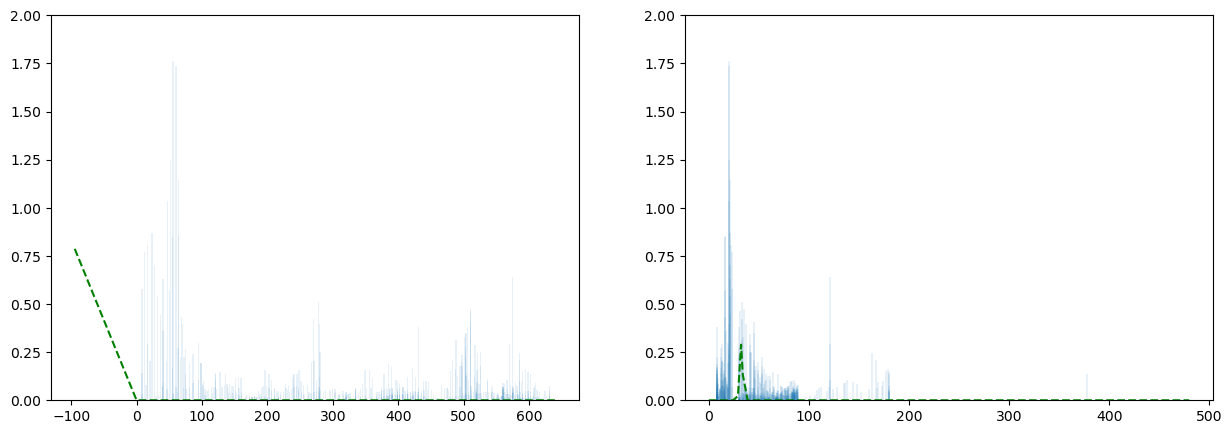

In [ ]:
plot_p_and_var(0, pred['keypoints1'], pred['gt_proj_0to1'], pred['gt_res0_1_sq'], pred['p_rp_01'], pred['logvar_01'])

In [ ]:
for k in data['view0']:
    print(k)

image
H_
coords
image_size


In [ ]:
data['view0']['image_size'].shape

torch.Size([1, 2])

In [ ]:
import cv2

def draw_keypoints_cv(image, kps, color = (0, 255, 0)):
  if image.shape[1] == 3:  # RGB
    scale = image.new_tensor([0.299, 0.587, 0.114]).view(1, 3, 1, 1)
    image = (image * scale).sum(1, keepdim=True)
  image = image.squeeze().detach().cpu().numpy()
  image = (image * 255).astype(np.uint8)
  kps = kps.squeeze().detach().cpu().numpy()
    
  cv_kps= [cv2.KeyPoint(kp[0], kp[1], 1) for kp in kps]
  out_img = cv2.drawKeypoints(image, cv_kps, None, color=color, flags=0)  

  return out_img

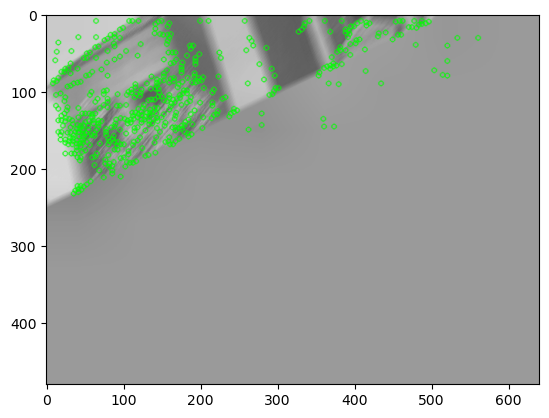

In [ ]:
img0 = draw_keypoints_cv(data['view0']['image'], pred['keypoints0'], color=(0,255,0))
plt.imshow(img0)
plt.show()

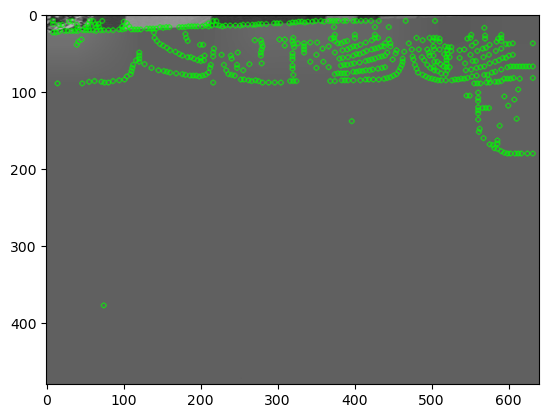

In [ ]:
img1 = draw_keypoints_cv(data['view1']['image'], pred['keypoints1'], color=(0,255,0))
plt.imshow(img1)
plt.show()

In [ ]:
img1_0 = draw_keypoints_cv(data['view0']['image'], pred['gt_proj1_0'], color=(0,255,0))
plt.imshow(img1_0)
plt.show()

KeyError: 'gt_proj1_0'

In [36]:
rootdir = "/is/cluster/fast/hli/tmp_revisitop1m/datasets/"
img_path = rootdir + "revisitop1m/jpg_tmp/a7f/a7f7c4959fcb63c3cf153961ff91f5c.jpg"

In [37]:
img = cv2.imread(img_path, cv2.IMREAD_COLOR)

Premature end of JPEG file


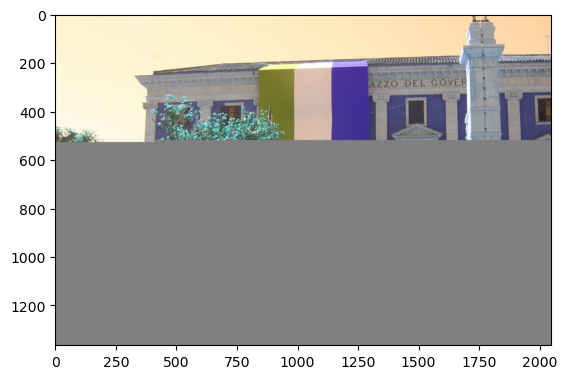

In [38]:
plt.imshow(img)
plt.show()

In [3]:
import os
import urllib.request
import tarfile
def download_distractors(data_dir):
    """
    DOWNLOAD_DISTRACTORS Checks, and, if required, downloads the distractor dataset.

    download_distractors(DATA_ROOT) checks if the distractor dataset exist.
    If not it downloads it in the folder:
        DATA_ROOT/datasets/revisitop1m/   : folder with 1M distractor images
    """

    # Create data folder if it does not exist
    if not os.path.isdir(data_dir):
        os.mkdir(data_dir)
    
    # Create datasets folder if it does not exist
    datasets_dir = os.path.join(data_dir, 'datasets')
    if not os.path.isdir(datasets_dir):
        os.mkdir(datasets_dir)

    dataset = 'revisitop1m'
    nfiles = 100
    src_dir = 'http://ptak.felk.cvut.cz/revisitop/revisitop1m/jpg'
    dl_files = 'revisitop1m.{}.tar.gz'
    dst_dir = os.path.join(data_dir, 'datasets', dataset, 'jpg')
    dst_dir_tmp = os.path.join(data_dir, 'datasets', dataset, 'jpg_tmp')
    if not os.path.isdir(dst_dir):
        print('>> Dataset {} directory does not exist.\n>> Creating: {}'.format(dataset, dst_dir))
        if not os.path.isdir(dst_dir_tmp):
            os.makedirs(dst_dir_tmp)
        for dfi in range(nfiles):
            if dfi < 29:
                continue
            dl_file = dl_files.format(dfi+1)
            src_file = os.path.join(src_dir, dl_file)
            dst_file = os.path.join(dst_dir_tmp, dl_file)
            dst_file_tmp = os.path.join(dst_dir_tmp, dl_file + '.tmp')
            if os.path.exists(dst_file):
                print('>> [{}/{}] Skipping dataset {} archive {}, already exists...'.format(dfi+1, nfiles, dataset, dl_file))
            else:
                n_tries = 0
                while n_tries < 3:
                    try:
                        print('>> [{}/{}] Downloading dataset {} archive {}...'.format(dfi+1, nfiles, dataset, dl_file))
                        urllib.request.urlretrieve(src_file, dst_file_tmp)
                        os.rename(dst_file_tmp, dst_file)
                        break
                    except:
                        print('>>>> Download failed. Try this one again...')
                        n_tries += 1
        for dfi in range(nfiles):
            if dfi < 29:
                continue
            dl_file = dl_files.format(dfi+1)
            try:
                dst_file = os.path.join(dst_dir_tmp, dl_file)
                print('>> [{}/{}] Extracting dataset {} archive {}...'.format(dfi+1, nfiles, dataset, dl_file))
                tar = tarfile.open(dst_file)
                tar.extractall(path=dst_dir_tmp)
                tar.close()
                print('>> [{}/{}] Extracted, deleting dataset {} archive {}...'.format(dfi+1, nfiles, dataset, dl_file))
                os.remove(dst_file)
            except:
                print('>> [{}/{}] Extraction failed for dataset {} archive {}...'.format(dfi+1, nfiles, dataset, dl_file))
        # rename tmp folder
        os.rename(dst_dir_tmp, dst_dir)

        # download image list
        gnd_src_dir = 'http://ptak.felk.cvut.cz/revisitop/revisitop1m/'
        gnd_dst_dir = os.path.join(data_dir, 'datasets', dataset)
        gnd_dl_file = '{}.txt'.format(dataset)
        gnd_src_file = os.path.join(gnd_src_dir, gnd_dl_file)
        gnd_dst_file = os.path.join(gnd_dst_dir, gnd_dl_file)
        if not os.path.exists(gnd_dst_file):
            print('>> Downloading dataset {} image list file...'.format(dataset))
            urllib.request.urlretrieve(gnd_src_file, gnd_dst_file)

In [4]:
dlpath = "/is/cluster/fast/hli/tmp_revisitop1m"
download_distractors(dlpath)

>> Dataset revisitop1m directory does not exist.
>> Creating: /is/cluster/fast/hli/tmp_revisitop1m/datasets/revisitop1m/jpg
>> [30/100] Downloading dataset revisitop1m archive revisitop1m.30.tar.gz...
>> [31/100] Downloading dataset revisitop1m archive revisitop1m.31.tar.gz...
>> [32/100] Skipping dataset revisitop1m archive revisitop1m.32.tar.gz, already exists...
>> [33/100] Skipping dataset revisitop1m archive revisitop1m.33.tar.gz, already exists...
>> [34/100] Skipping dataset revisitop1m archive revisitop1m.34.tar.gz, already exists...
>> [35/100] Skipping dataset revisitop1m archive revisitop1m.35.tar.gz, already exists...
>> [36/100] Skipping dataset revisitop1m archive revisitop1m.36.tar.gz, already exists...
>> [37/100] Skipping dataset revisitop1m archive revisitop1m.37.tar.gz, already exists...
>> [38/100] Skipping dataset revisitop1m archive revisitop1m.38.tar.gz, already exists...
>> [39/100] Skipping dataset revisitop1m archive revisitop1m.39.tar.gz, already exists...
>>